In [6]:
import requests
import gcsfs
import dask
import os
import os.path
import pickle
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://quoting-wasp-dask-scheduler:8786 Dashboard: http://quoting-wasp-dask-scheduler:8787/status,Cluster Workers: 6 Cores: 6 Memory: 30.00 GB


Test our connection to gcs - if no token, create one.

In [8]:
if not os.path.exists('../../.gcs_tokens'):
    # Get a token
    gcsfs.GCSFileSystem(project='neuron-jungle', token='browser')

In [9]:
with open('../../.gcs_tokens', 'rb') as f:
    credentials = pickle.load(f)
credentials = credentials[list(credentials.keys())[0]]
fs = gcsfs.GCSFileSystem(project='neuron-jungle', token=credentials)
fs.ls('l4dense')

['l4dense/segmentation-volume/']

Success! Now we try fetching one shard of data and posting it to our filesystem. 

In [11]:
def download(filename):
    url = f"https://l4dense2019.brain.mpg.de/webdav/{filename}"
    result = requests.get(url, verify=False)
    result.raise_for_status()
    return result.content

def upload(filename, data, credentials):
    fs = gcsfs.GCSFileSystem(project='neuron-jungle', token=credentials)
    with fs.open(f'l4dense/{filename}', 'wb') as f:
        num_bytes = f.write(data)
    return num_bytes

@dask.delayed
def mirror(filename):
    print(f"Fetching {filename}")
    data = download(filename)
    num_bytes = upload(filename, data, credentials)
    return num_bytes

filename = "segmentation-volume/x0y0z0.hdf5"
mirror(filename).compute()

141523360

Now do it across all the files.

In [32]:
num_bytes = []

for i in range(6):
    for j in range(9):
        for k in range(4):
            filename = f'segmentation-volume/x{i}y{j}z{k}.hdf5'
            num_bytes.append(mirror(filename))
    
total_bytes = sum(num_bytes)
total_bytes.compute()

28400344303

Visualize a smaller version of the computation graph.

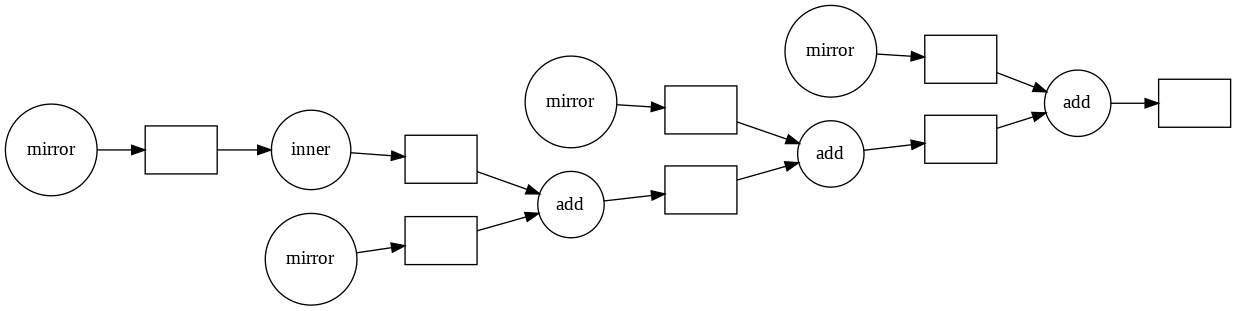

In [12]:
num_bytes = []

i, j = 0, 0
for k in range(4):
    filename = f'segmentation-volume/x{i}y{j}z{k}.hdf5'
    num_bytes.append(mirror(filename))
    
total_bytes = sum(num_bytes)
total_bytes.visualize(rankdir='LR')